
=== Reliable Node Then Failing ===
Audit 50: Score=1.0000, Unknown=1.0000, DQ=False
Audit 100: Score=1.0000, Unknown=1.0000, DQ=False
Audit 150: Score=1.0000, Unknown=1.0000, DQ=False
Audit 200: Score=1.0000, Unknown=1.0000, DQ=False
Audit 250: Score=1.0000, Unknown=1.0000, DQ=False
Audit 300: Score=1.0000, Unknown=1.0000, DQ=False
Audit 350: Score=1.0000, Unknown=1.0000, DQ=False
Audit 400: Score=1.0000, Unknown=1.0000, DQ=False
Audit 450: Score=1.0000, Unknown=1.0000, DQ=False
Audit 500: Score=1.0000, Unknown=1.0000, DQ=False
Audit 550: Score=0.8093, Unknown=1.0000, DQ=True
Audit 600: Score=0.8830, Unknown=1.0000, DQ=True
Audit 650: Score=0.9286, Unknown=1.0000, DQ=True

=== Gradual Degradation ===
Audit 50: Score=1.0000, Unknown=1.0000, DQ=False
Audit 100: Score=1.0000, Unknown=1.0000, DQ=False
Audit 150: Score=1.0000, Unknown=1.0000, DQ=False
Audit 200: Score=1.0000, Unknown=1.0000, DQ=False
Audit 250: Score=0.9936, Unknown=1.0000, DQ=False
Audit 300: Score=0.9849, Unknown=1.0000,

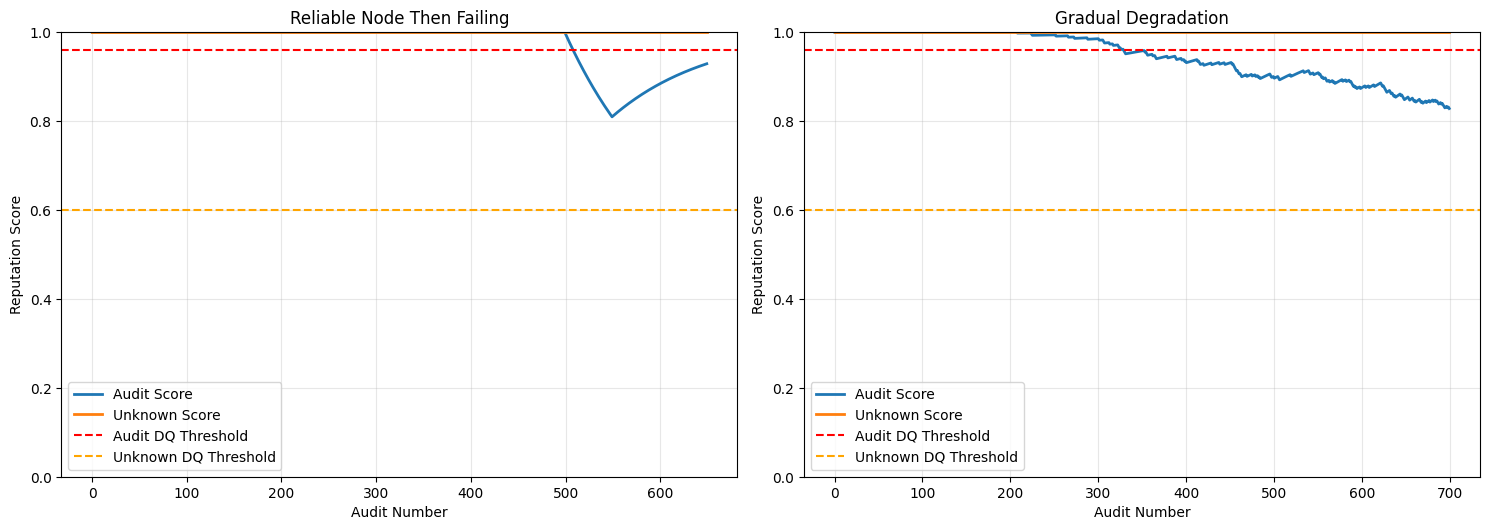


=== Reliable Node Then Failing ===
Audit 50: Score=1.0000, Unknown=1.0000, DQ=False
Audit 100: Score=1.0000, Unknown=1.0000, DQ=False
Audit 150: Score=1.0000, Unknown=1.0000, DQ=False
Audit 200: Score=1.0000, Unknown=1.0000, DQ=False
Audit 250: Score=1.0000, Unknown=1.0000, DQ=False
Audit 300: Score=1.0000, Unknown=1.0000, DQ=False
Audit 350: Score=1.0000, Unknown=1.0000, DQ=False
Audit 400: Score=1.0000, Unknown=1.0000, DQ=False
Audit 450: Score=1.0000, Unknown=1.0000, DQ=False
Audit 500: Score=1.0000, Unknown=1.0000, DQ=False
Audit 550: Score=0.8093, Unknown=1.0000, DQ=True
Audit 600: Score=0.8830, Unknown=1.0000, DQ=True
Audit 650: Score=0.9286, Unknown=1.0000, DQ=True

Reliable Node Then Failing Final Results:
  Final Audit Score: 0.9286
  Final Unknown Score: 1.0000
  Disqualified: True
  Disqualified at audit: 509

=== Gradual Degradation ===
Audit 50: Score=1.0000, Unknown=1.0000, DQ=False
Audit 100: Score=1.0000, Unknown=1.0000, DQ=False
Audit 150: Score=1.0000, Unknown=1.0000

In [3]:
import numpy as np  
import matplotlib.pyplot as plt  
  
class NodeReputationSimulator:  
    def __init__(self):  
        # Configuration from satellite/reputation/config.go  
        self.audit_lambda = 0.99  
        self.unknown_audit_lambda = 0.95  
        self.audit_weight = 1.0
        self.audit_dq = 0.96  
        self.unknown_audit_dq = 0.6  
        self.initial_alpha = 1000.0  
        self.initial_beta = 0.0  
          
        # Initialize reputation  
        self.audit_alpha = self.initial_alpha  
        self.audit_beta = self.initial_beta  
        self.unknown_audit_alpha = 1.0  
        self.unknown_audit_beta = 0.0  
          
        self.history = []  
          
    def update_reputation_multiple(self, beta, alpha, lambda_val, weight, success):  
        """Implementation of UpdateReputationMultiple from reputation package"""  
        v = 1.0 if success else 0.0
        alpha = lambda_val * alpha + weight*(1+v)/2
        beta = lambda_val * beta + weight*(1-v)/2
        return beta, alpha  
      
    def apply_audit_result(self, result_type):  
        """Apply audit results: 'success', 'failure', 'unknown', 'offline'"""  
        if result_type == 'failure':  
            self.audit_beta, self.audit_alpha = self.update_reputation_multiple(  
                self.audit_beta, self.audit_alpha, self.audit_lambda, self.audit_weight, False
            )  
        elif result_type == 'unknown':  
            self.unknown_audit_beta, self.unknown_audit_alpha = self.update_reputation_multiple(  
                self.unknown_audit_beta, self.unknown_audit_alpha,   
                self.unknown_audit_lambda, self.audit_weight, False  
            )  
        elif result_type == 'success':  
            # Success improves both normal and unknown reputation  
            self.audit_beta, self.audit_alpha = self.update_reputation_multiple(  
                self.audit_beta, self.audit_alpha, self.audit_lambda, self.audit_weight, True  
            )  
            self.unknown_audit_beta, self.unknown_audit_alpha = self.update_reputation_multiple(  
                self.unknown_audit_beta, self.unknown_audit_alpha,  
                self.unknown_audit_lambda, self.audit_weight, True  
            )  
          
        # Record current state  
        audit_score = self.audit_alpha / (self.audit_alpha + self.audit_beta)  
        unknown_score = self.unknown_audit_alpha / (self.unknown_audit_alpha + self.unknown_audit_beta)  
          
        self.history.append({  
            'audit_score': audit_score,  
            'unknown_score': unknown_score,  
            'audit_alpha': self.audit_alpha,  
            'audit_beta': self.audit_beta,  
            'unknown_alpha': self.unknown_audit_alpha,  
            'unknown_beta': self.unknown_audit_beta,  
            'disqualified': audit_score <= self.audit_dq or unknown_score <= self.unknown_audit_dq  
        })  
      
    def simulate_scenario(self, scenario_name, events):  
        """Simulate a sequence of audit events"""  
        print(f"\n=== {scenario_name} ===")  
        self.__init__()  # Reset  
          
        for event in events:  
            self.apply_audit_result(event['type'])  
            if len(self.history) % 50 == 0:  # Print every 50 audits  
                last = self.history[-1]  
                print(f"Audit {len(self.history)}: Score={last['audit_score']:.4f}, "  
                      f"Unknown={last['unknown_score']:.4f}, DQ={last['disqualified']}")  
          
        return self.history  
  
# Scenario 1: Reliable node that suddenly starts failing  
def scenario_reliable_then_failing():  
    events = []  
    # 500 successful audits (building good reputation)  
    events.extend([{'type': 'success'} for _ in range(500)])  
    # Sudden failure period - 50 failures  
    events.extend([{'type': 'failure'} for _ in range(50)])  
    # Try to recover with successes  
    events.extend([{'type': 'success'} for _ in range(100)])  
    return events  
  
# Scenario 2: Node with intermittent unknown errors  
def scenario_unknown_errors():  
    events = []  
    # Start with good reputation  
    events.extend([{'type': 'success'} for _ in range(200)])  
    # Period of unknown errors (timeouts)  
    for _ in range(100):  
        if np.random.random() < 0.3:  # 30% unknown error rate  
            events.append({'type': 'unknown'})  
        else:  
            events.append({'type': 'success'})  
    return events  
  
# Scenario 3: Gradual degradation  
def scenario_gradual_degradation():  
    events = []  
    # Start reliable  
    events.extend([{'type': 'success'} for _ in range(200)])  
      
    # Gradually increase failure rate  
    for phase in range(10):  
        failure_rate = 0.05 + (phase * 0.05)  # 5% to 50% failure rate  
        for _ in range(50):  
            if np.random.random() < failure_rate:  
                events.append({'type': 'failure'})  
            else:  
                events.append({'type': 'success'})  
    return events  
  
# Run simulations  
simulator = NodeReputationSimulator()  
  
scenarios = [  
    ("Reliable Node Then Failing", scenario_reliable_then_failing()),  
    # ("Unknown Errors", scenario_unknown_errors()),  
    ("Gradual Degradation", scenario_gradual_degradation())  
]  
  
plt.figure(figsize=(15, 10))  
  
for i, (name, events) in enumerate(scenarios):  
    history = simulator.simulate_scenario(name, events)  
      
    plt.subplot(2, 2, i+1)  
    audit_scores = [h['audit_score'] for h in history]  
    unknown_scores = [h['unknown_score'] for h in history]  
      
    plt.plot(audit_scores, label='Audit Score', linewidth=2)  
    plt.plot(unknown_scores, label='Unknown Score', linewidth=2)  
    plt.axhline(y=0.96, color='red', linestyle='--', label='Audit DQ Threshold')  
    plt.axhline(y=0.6, color='orange', linestyle='--', label='Unknown DQ Threshold')  
      
    plt.title(name)  
    plt.xlabel('Audit Number')  
    plt.ylabel('Reputation Score')  
    plt.legend()  
    plt.grid(True, alpha=0.3)  
    plt.ylim(0, 1)  
  
plt.tight_layout()  
plt.show()  
  
# Print final statistics  
for name, events in scenarios:  
    history = simulator.simulate_scenario(name, events)  
    final = history[-1]  
    dq_point = next((i for i, h in enumerate(history) if h['disqualified']), None)  
      
    print(f"\n{name} Final Results:")  
    print(f"  Final Audit Score: {final['audit_score']:.4f}")  
    print(f"  Final Unknown Score: {final['unknown_score']:.4f}")  
    print(f"  Disqualified: {final['disqualified']}")  
    if dq_point:  
        print(f"  Disqualified at audit: {dq_point + 1}")